In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Deep learning (future use, not yet applied here)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Plot settings
plt.style.use("seaborn-v0_8")
sns.set_theme()

In [2]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,02/10/2012 09:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,02/10/2012 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,02/10/2012 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,02/10/2012 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,02/10/2012 13:00,4918


In [3]:
def check_columns(df: pd.DataFrame):

    print("\n Column Info")
    print(df.info())

    print("\nMissing Values")
    print(df.isna().sum())

    print("\n Sample Unique Values")
    for col in df.columns:
        uniques = df[col].unique()
        print(f"\n{col}: {len(uniques)} unique values")
        print("Sample:", uniques[:10])


In [4]:
# call fxn
check_columns(df)



 Column Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB
None

Missing Values
holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volum


### **About dataset**

### Dataset: Metro Interstate Traffic Volume

- Hourly traffic volume records from 2012–2018.
- Features:
    - **holiday**: US holiday name if applicable, else None.
    - **temp**: Temperature in Kelvin (to be converted to °C).
    - **rain_1h**: Rainfall in mm last hour.
    - **snow_1h**: Snowfall in mm last hour.
    - **clouds_all**: Cloud coverage (0–100).
    - **weather_main**: General weather condition.
    - **weather_description**: More detailed weather description.
    - **date_time**: Timestamp.
    - **traffic_volume**: Target = cars counted that hour.

**Flow:**
Load → Audit → Preprocess → EDA → Encode → Save.

In [5]:
# PREPROCESSING FUNCTION
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and engineer features: datetime, temp, rain, snow, clouds."""
    
    # 1. Parse datetime
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
    
    # 2. Convert temp (K → °C)
    df['temp_c'] = df['temp'] - 273.15
    
    # 3. Cap unrealistic rain > 50 mm/hr
    df['rain_1h'] = np.where(df['rain_1h'] > 50, 50, df['rain_1h'])
    
    # 4. Snow is already in small values, so leave as it is...
    
    # 5. Ensure clouds_all is within 0–100
    df['clouds_all'] = df['clouds_all'].clip(0, 100)
    
    # 6. Extract datetime features
    df['hour'] = df['date_time'].dt.hour
    df['dayofweek'] = df['date_time'].dt.dayofweek  # 0=Mon, 6=Sun
    df['month'] = df['date_time'].dt.month
    df['year'] = df['date_time'].dt.year
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    
    # 7. Set datetime index
    df = df.set_index('date_time').sort_index()
    
    
    #df.index.duplicated().any()
    #df.index.duplicated().sum()
    #df[df.index.duplicated(keep=False)].sort_index().head(20)
    
    #8. Remove duplicate datetime rows
    before = df.shape[0]
    df = df[~df.index.duplicated(keep='first')]
    after = df.shape[0]
    print(f"Removed {before - after} duplicate rows.")


    return df

#call fxn
df_clean = preprocess(df)


Removed 32067 duplicate rows.


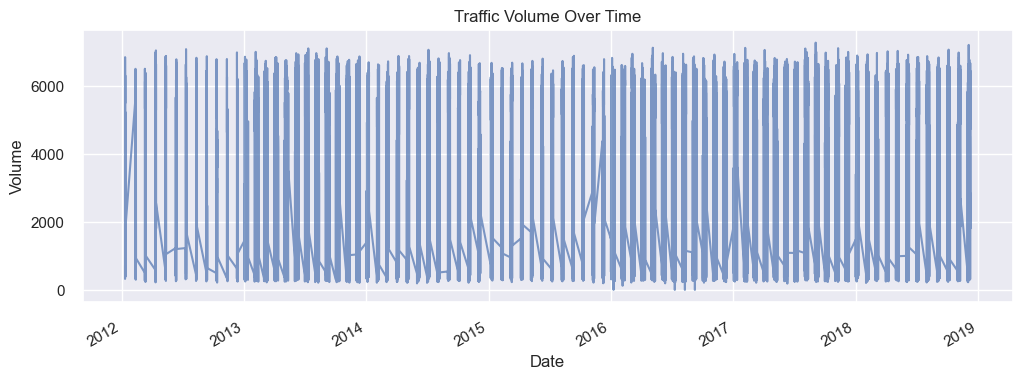

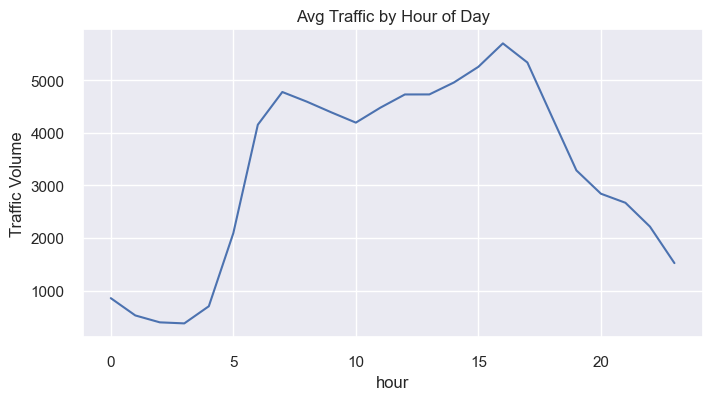

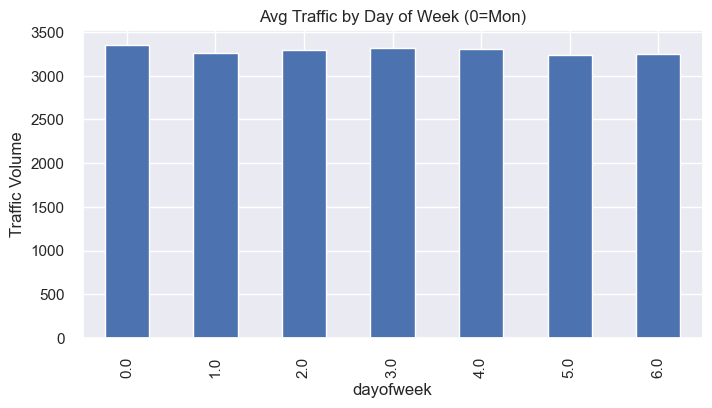

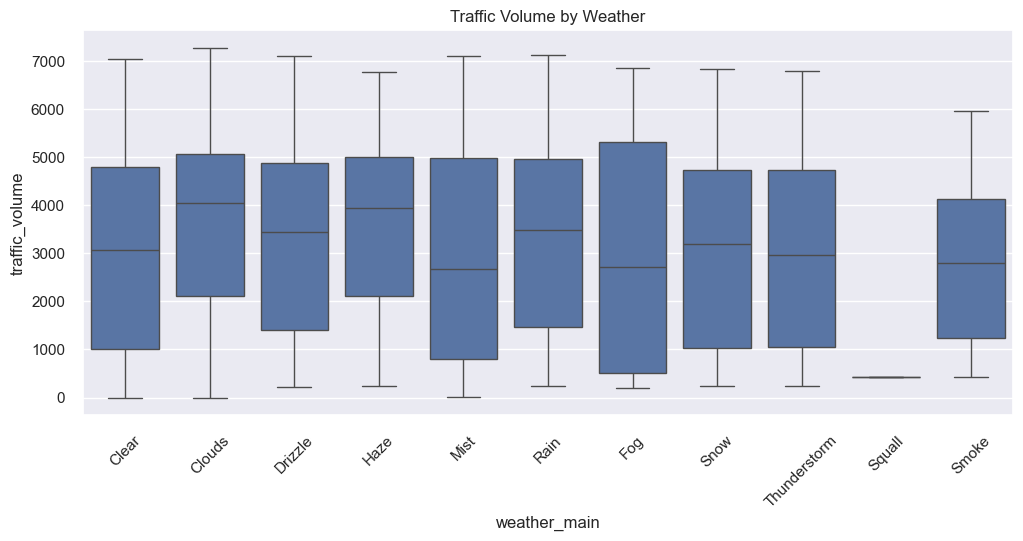

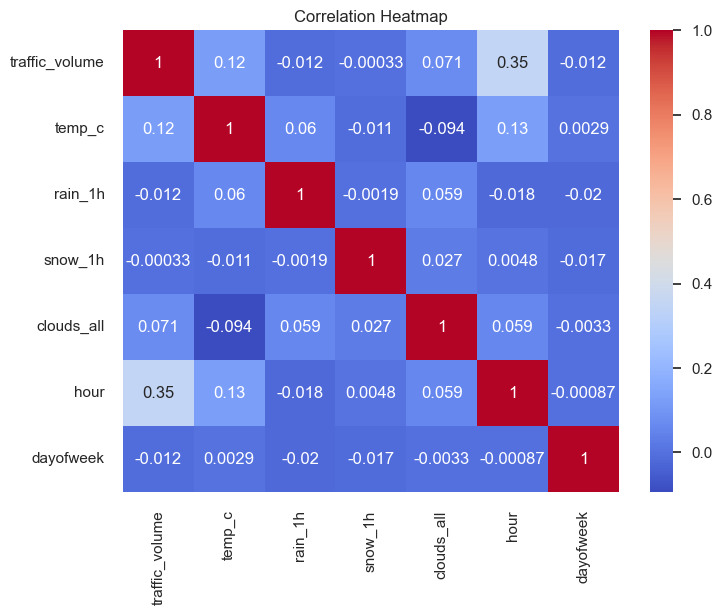

In [6]:
# EDA FUNCTION
#EDA run only after preprocessing.
def run_eda(df: pd.DataFrame):
    """Basic exploratory plots for traffic data."""
    
    # Traffic volume over time
    plt.figure(figsize=(12,4))
    df['traffic_volume'].plot(alpha=0.7)
    plt.title('Traffic Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.show()

    # Avg traffic by hour
    plt.figure(figsize=(8,4))
    df.groupby('hour')['traffic_volume'].mean().plot(kind='line')
    plt.title('Avg Traffic by Hour of Day')
    plt.ylabel('Traffic Volume')
    plt.show()

    # Avg traffic by day of week
    plt.figure(figsize=(8,4))
    df.groupby('dayofweek')['traffic_volume'].mean().plot(kind='bar')
    plt.title('Avg Traffic by Day of Week (0=Mon)')
    plt.ylabel('Traffic Volume')
    plt.show()

    # Weather impact
    plt.figure(figsize=(12,5))
    sns.boxplot(x='weather_main', y='traffic_volume', data=df.reset_index())
    plt.xticks(rotation=45)
    plt.title('Traffic Volume by Weather')
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(df[['traffic_volume','temp_c','rain_1h','snow_1h','clouds_all','hour','dayofweek']].corr(),
                annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

# call fxn: Run EDA 
run_eda(df_clean)


### **Traffic Volume Over Time (2012-2019)**
The time series shows consistent weekly patterns throughout the dataset with regular spikes and troughs. Traffic volumes typically range between 0-7000 vehicles, with a noticeable weekly cyclical pattern (the repeated peaks and valleys). There's no significant long-term trend - traffic levels remain relatively stable across the 7-year period. The regular drops to near-zero likely represent nighttime hours or weekends.

### **Average Traffic by Hour of Day**
Traffic exhibits a bimodal distribution with two distinct peaks:
- Morning rush hour: Traffic climbs sharply from ~500 at 5 AM to ~4,800 by 7-8 AM
- Evening peak: Traffic reaches its maximum around 2-3 PM (~5,500 vehicles) before declining
- Overnight lull: Lowest traffic occurs between midnight and 5 AM (~500-1000 vehicles)

(typical of commuter/urban traffic with morning and afternoon peaks.)

### **Average Traffic by Day of Week**
Traffic volume is remarkably consistent across all days (~3,200 vehicles/day average). There's minimal variation between weekdays and weekends, with only slight differences:

- Monday (0), Wednesday (2), and Friday (4) show marginally higher volumes
- Weekend (5=Saturday, 6=Sunday) are nearly identical to weekdays

### **Traffic Volume by Weather Condition**
Weather shows mid impact on traffic:

Squall conditions produce the lowest median traffic (~1,800) and smallest range
Clear, cloudy, drizzle, haze, and mist conditions all show similar median values (~3,000-4,000)
Rain, fog, snow, and thunderstorm have comparable distributions to normal conditions
Most weather conditions show large variability (wide boxes and whiskers), indicating weather alone doesn't determine traffic

The outliers suggest traffic volume is more strongly influenced by **time of day** than weather.

### **Correlation Heatmap**

- Hour has the strongest correlation with traffic volume (r=0.35) - time of day is the primary driver
- Temperature shows weak positive correlation (r=0.13) - slightly more traffic in warmer weather
- All other variables show negligible correlations (|r| < 0.1):

    Rain, snow, clouds: minimal impact

    Day of week: essentially no correlation (-0.013)


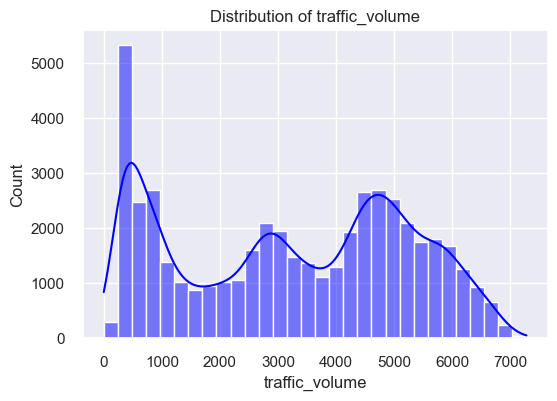

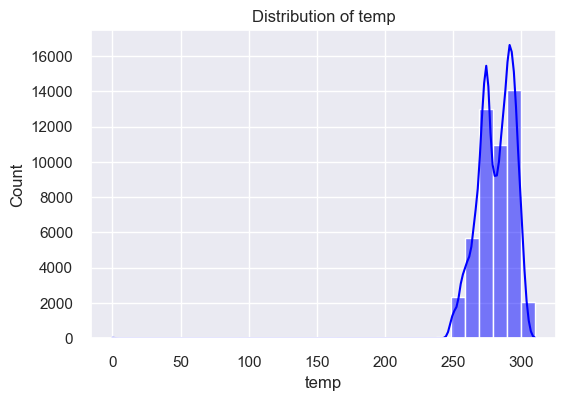

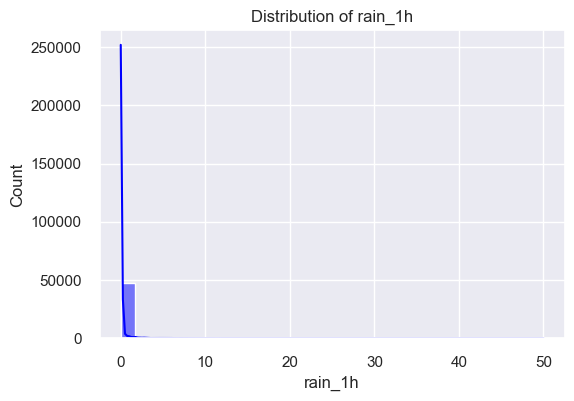

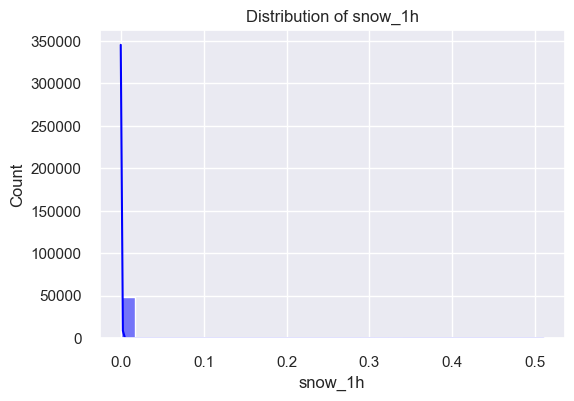

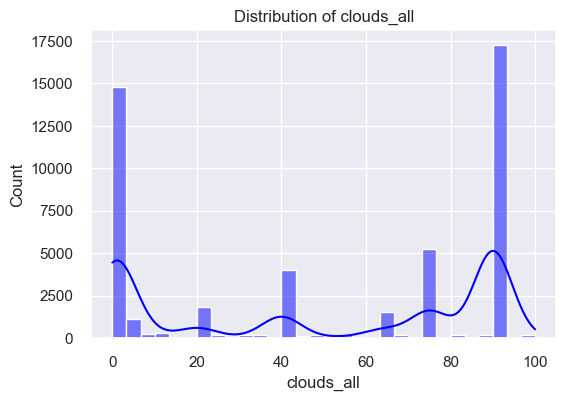

In [7]:
def plot_distributions(df, cols, bins=30):
    """Plot histograms with KDE to check normality visually."""
    for col in cols:
        plt.figure(figsize=(6,4))
        sns.histplot(df[col], bins=bins, kde=True, color="blue")
        plt.title(f"Distribution of {col}")
        plt.show()

# Example: check numeric features
numeric_cols = ['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all']

plot_distributions(df, numeric_cols)

In [ ]:
from scipy.stats import shapiro, normaltest

def test_normality(df, cols):
    results = {}
    for col in cols:
        data = df[col].dropna()
        
        # Shapiro-Wilk Test
        shapiro_stat, shapiro_p = shapiro(data.sample(5000, random_state=42) if len(data) > 5000 else data)
        
        # D’Agostino and Pearson’s test
        dagostino_stat, dagostino_p = normaltest(data)
        
        results[col] = {
            "Shapiro p-value": shapiro_p,
            "D’Agostino p-value": dagostino_p
        }
    
    return pd.DataFrame(results).T

normality_results = test_normality(df, numeric_cols)
print(normality_results)


                Shapiro p-value  D’Agostino p-value
traffic_volume     9.293055e-43                 0.0
temp               6.135078e-47                 0.0
rain_1h            2.823688e-93                 0.0
snow_1h            1.861102e-95                 0.0
clouds_all         8.105226e-64                 0.0


In [9]:
# ENCODING FUNCTIONS
def encode_cyclical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Encode cyclical features (hour, dayofweek) using sine/cosine."""
    
    if 'hour' in df.columns:
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    if 'dayofweek' in df.columns:
        df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    return df


def encode_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    """One-hot encode categorical features."""
    
    # Handle missing holidays
    if 'holiday' in df.columns:
        df['holiday'] = df['holiday'].fillna('None')
    
    # Detect categoricals
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if categorical_cols:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded = encoder.fit_transform(df[categorical_cols])
        
        encoded_df = pd.DataFrame(
            encoded,
            columns=encoder.get_feature_names_out(categorical_cols),
            index=df.index
        )
        
        df = df.drop(columns=categorical_cols)
        df = pd.concat([df, encoded_df], axis=1)
    
    return df


#call fxn: Apply encodings
df_clean = encode_cyclical_features(df_clean)
df_clean = encode_categoricals(df_clean)


In [10]:
print("Before shape:", df.shape)
print("Cleaned dataset shape:", df_clean.shape)
print("Columns after encoding:\n", df_clean.columns[:20])  # first 20 cols
df_clean.head()

Before shape: (48204, 15)
Cleaned dataset shape: (16137, 64)
Columns after encoding:
 Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'temp_c',
       'hour', 'dayofweek', 'month', 'year', 'is_weekend', 'hour_sin',
       'hour_cos', 'dow_sin', 'dow_cos', 'holiday_Columbus Day',
       'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_New Years Day', 'holiday_None'],
      dtype='object')


,temp,rain_1h,snow_1h,clouds_all,traffic_volume,temp_c,hour,dayofweek,month,year,...,weather_description_shower drizzle,weather_description_sky is clear,weather_description_smoke,weather_description_snow,weather_description_thunderstorm,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_thunderstorm with rain,weather_description_very heavy rain
date_time,,,,,,,,,,,,,,,,,,,,,
2012-01-11 00:00:00,271.73,0.0,0.0,1,716,-1.42,0.0,2.0,1.0,2012.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 01:00:00,270.91,0.0,0.0,1,453,-2.24,1.0,2.0,1.0,2012.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 02:00:00,270.15,0.0,0.0,1,324,-3.00,2.0,2.0,1.0,2012.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 03:00:00,269.68,0.0,0.0,1,390,-3.47,3.0,2.0,1.0,2012.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-11 04:00:00,269.44,0.0,0.0,1,775,-3.71,4.0,2.0,1.0,2012.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# SAVE CLEANED DATA
df_clean.to_csv("data_cleaned.csv", index=True)
#keeps datetime index
print("Cleaned dataset saved to data_cleaned.csv")

Cleaned dataset saved to data_cleaned.csv


In [12]:
import pandas as pd
import numpy as np

# 1. LOAD RAW DATA
df = pd.read_csv("data_cleaned.csv", parse_dates=["date_time"], index_col="date_time")

# 2. CREATE ALL FEATURES (do this once for everyone)
# Lag features
df['traffic_lag_1'] = df['traffic_volume'].shift(1)
df['traffic_lag_24'] = df['traffic_volume'].shift(24)
df['traffic_lag_168'] = df['traffic_volume'].shift(168)

# Rolling statistics
df['traffic_rolling_mean_24'] = df['traffic_volume'].rolling(24).mean()
df['traffic_rolling_std_24'] = df['traffic_volume'].rolling(24).std()

# Time features (if not already present)
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Holiday flag (if not already present)
if 'is_holiday' not in df.columns:
    holiday_cols = [c for c in df.columns if c.startswith('holiday_')]
    if holiday_cols:
        df['is_holiday'] = (df[holiday_cols].sum(axis=1) > 0).astype(int)

# 3. DROP NaNs (from lags/rolling)
df = df.dropna()

# 4. DEFINE SINGLE TRAIN/TEST SPLIT
TEST_SIZE = 24 * 30  # Last 30 days
train = df.iloc[:-TEST_SIZE]
test = df.iloc[-TEST_SIZE:]

print(f"Train: {train.index.min()} to {train.index.max()} ({len(train)} hours)")
print(f"Test:  {test.index.min()} to {test.index.max()} ({len(test)} hours)")

# 5. SAVE FOR ALL MODELS TO USE
train.to_csv("data_train.csv")
test.to_csv("data_test.csv")


Train: 2012-03-12 14:00:00 to 2018-09-06 21:00:00 (15248 hours)
Test:  2018-09-06 22:00:00 to 2018-12-09 23:00:00 (720 hours)


***The project is about comparing different forecasting models to see which one best predicts future traffic volumes, so that city/urban planners or traffic managers can use it for decision-making.***